In [1]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time
import copy


# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cuda = torch.cuda.is_available()

cpu


In [3]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [6]:
# train_X = torch.tensor(train_X).permute(0, 3, 1, 2).float()
# test_X = torch.tensor(test_X).permute(0, 3, 1, 2).float()
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_9580\3739243810.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
C:\Users\Rajeev Wankar\AppData\Local\Temp\ipykernel_9580\3739243810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.int64).to(device)


In [7]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)

hessian_loader = []
for i, (x, y) in enumerate(dataloader):
    hessian_loader.append((x.to(device), y.to(device)))
    
model_SGD = Net().to(device)
model_Adam = copy.deepcopy(model_SGD)
model_adagrad = copy.deepcopy(model_SGD)
criterion = nn.CrossEntropyLoss()
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=1e-2)
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=1e-2)
# Optimizer for using dominant k eigenvalues of the hessian as a preconditioner.
optimizer_adagrad = torch.optim.Adagrad(model_adagrad.parameters(), lr=1e-2)

In [8]:
# Training
train_losses_SGD = []
train_losses_Adam = []
train_losses_adagrad = []
traces_SGD = []
traces_Adam = []
traces_adagrad = []
epochs = 50
hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adagrad = hessian(model_adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
traces_SGD.append(np.mean(hessian_sgd.trace()))
traces_Adam.append(np.mean(hessian_adam.trace()))
traces_adagrad.append(np.mean(hessian_adagrad.trace()))
for epoch in range(epochs):
    model_SGD.train()
    model_Adam.train()
    model_adagrad.train()
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_SGD.zero_grad()
        optimizer_Adam.zero_grad()
        optimizer_adagrad.zero_grad()
        y_pred_SGD = model_SGD(x_batch)
        y_pred_Adam = model_Adam(x_batch)
        y_pred_adagrad = model_adagrad(x_batch)
        loss_SGD = criterion(y_pred_SGD, y_batch)
        loss_Adam = criterion(y_pred_Adam, y_batch)
        loss_adagrad = criterion(y_pred_adagrad, y_batch)
        train_losses_SGD.append(loss_SGD.item())
        train_losses_Adam.append(loss_Adam.item())
        train_losses_adagrad.append(loss_adagrad.item())
        loss_SGD.backward()
        loss_Adam.backward()
        loss_adagrad.backward()
        optimizer_SGD.step()
        optimizer_Adam.step()
        optimizer_adagrad.step()
        # with torch.enable_grad():
        #     x_batch.requires_grad_(True)
        #     hess = hessian(model_adagrad, criterion, data=(x_batch, y_batch), cuda=cuda)
        #     eigvals, eigvecs = hess.eigenvalues(top_n=10)
        #     # Update each parameter's gradient using the eigenvalue preconditioner
        #     for param in model_adagrad.parameters():
        #         if param.grad is not None:
        #             grad = param.grad.view(-1)
        #             precond_grad = torch.zeros_like(grad)
        #             for i, vec in enumerate(eigvecs):
        #                 vec_flat = vec.view(-1)
        #                 # Avoid division by zero if any eigenvalue is very small
        #                 inv_eig = 1.0 / (eigvals[i] + 1e-12)
        #                 precond_grad += inv_eig * torch.dot(vec_flat, grad) * vec_flat
        #             param.grad.copy_(precond_grad.view_as(param.grad))
        #     optimizer_adagrad.step()
        print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_adagrad: {loss_adagrad.item()}")
    print(f"Epoch {epoch+1}/{epochs}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_adagrad: {loss_adagrad.item()}")
    hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
    hessian_adagrad = hessian(model_adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
    traces_SGD.append(np.mean(hessian_sgd.trace()))
    traces_Adam.append(np.mean(hessian_adam.trace()))
    traces_adagrad.append(np.mean(hessian_adagrad.trace()))
    # get_esd_plot(*hessian_sgd.density(), title=f'SGD Epoch {epoch+1} (Loss: {loss_SGD.item()}), trace: {traces_SGD[-1]}')
    # get_esd_plot(*hessian_adam.density(), title=f'Adam Epoch {epoch+1} (Loss: {loss_Adam.item()}), trace: {traces_Adam[-1]}')
    # get_esd_plot(*hessian_adagrad.density(), title=f'Adagrad Epoch {epoch+1} (Loss: {loss_adagrad.item()}, trace: {traces_adagrad[-1]})')
    print(f"Epoch {epoch+1}/{epochs}, Trace_SGD: {traces_SGD[-1]}, Trace_Adam: {traces_Adam[-1]}, Trace_adagrad: {traces_adagrad[-1]}") 

d:\miniconda3\envs\deephessian\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\b\abs_fakvb73nko\croot\pytorch-select_1730848725921\work\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50, Batch 1/32, Loss_SGD: 2.283198833465576, Loss_Adam: 2.283198833465576, Loss_adagrad: 2.283198833465576
Epoch 1/50, Batch 2/32, Loss_SGD: 2.275059700012207, Loss_Adam: 2.0620734691619873, Loss_adagrad: 2.0620548725128174
Epoch 1/50, Batch 3/32, Loss_SGD: 2.2668707370758057, Loss_Adam: 1.8975554704666138, Loss_adagrad: 1.9206219911575317
Epoch 1/50, Batch 4/32, Loss_SGD: 2.2945661544799805, Loss_Adam: 1.954085111618042, Loss_adagrad: 2.054192066192627
Epoch 1/50, Batch 5/32, Loss_SGD: 2.2793362140655518, Loss_Adam: 1.4326750040054321, Loss_adagrad: 1.681596279144287
Epoch 1/50, Batch 6/32, Loss_SGD: 2.2973954677581787, Loss_Adam: 1.4823182821273804, Loss_adagrad: 1.6646718978881836
Epoch 1/50, Batch 7/32, Loss_SGD: 2.2804291248321533, Loss_Adam: 1.2077515125274658, Loss_adagrad: 1.355290174484253
Epoch 1/50, Batch 8/32, Loss_SGD: 2.297868490219116, Loss_Adam: 1.1619243621826172, Loss_adagrad: 1.2915267944335938
Epoch 1/50, Batch 9/32, Loss_SGD: 2.278660774230957, Loss_Adam: 1

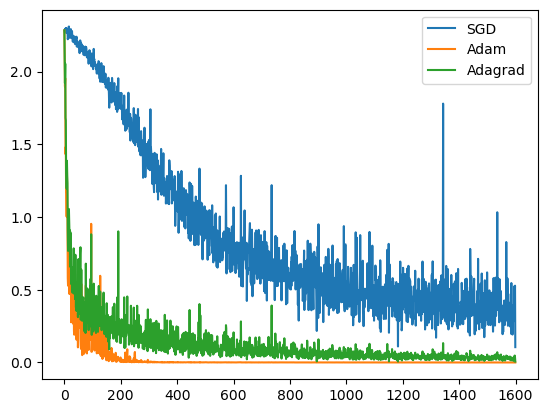

In [9]:
# Plotting the loss curves
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_adagrad, label='Adagrad')
plt.legend()
plt.show()

In [10]:
# Saving the loss arrays
# np.save('train_losses_SGD.npy', train_losses_SGD)
# np.save('train_losses_Adam.npy', train_losses_Adam)
# np.save('train_losses_Domke.npy', train_losses_Domke)

c:\Users\Rajeev Wankar\Desktop\Aarsh IITGN\Project Course - Sem 4\DeepHessian\PyHessian\density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


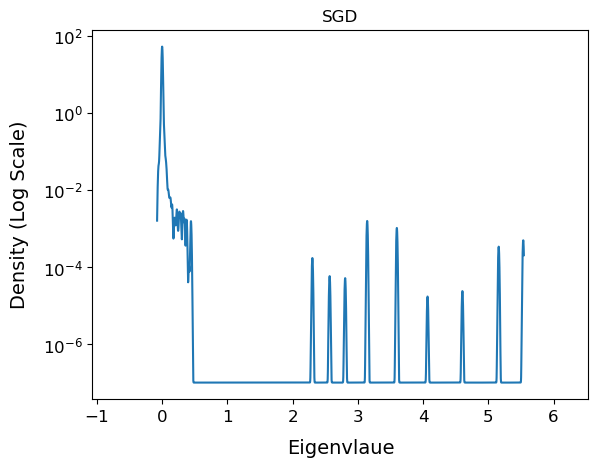

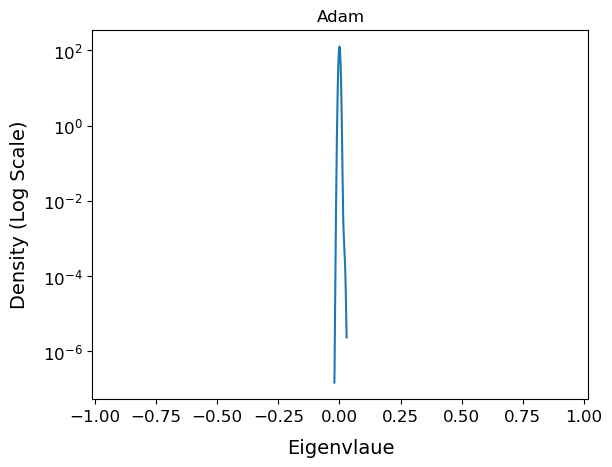

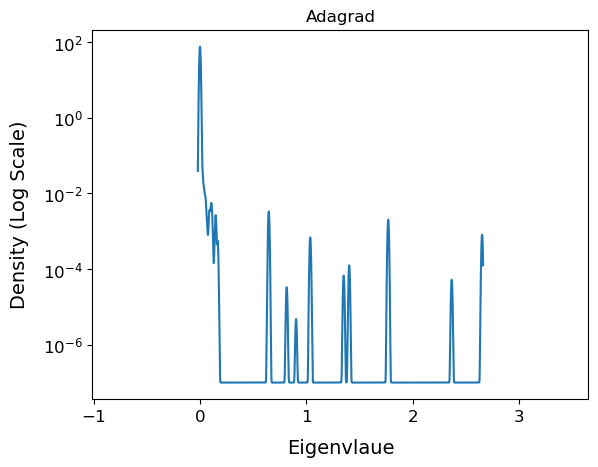

In [11]:
# Plot the ESD of the Hessian in all three cases
hessian_sgd = hessian(model_SGD, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adam = hessian(model_Adam, criterion, dataloader=hessian_loader, cuda=cuda)
hessian_adagrad = hessian(model_adagrad, criterion, dataloader=hessian_loader, cuda=cuda)
get_esd_plot(*hessian_sgd.density(), title='SGD')
get_esd_plot(*hessian_adam.density(), title='Adam')
get_esd_plot(*hessian_adagrad.density(), title='Adagrad')
plt.show()


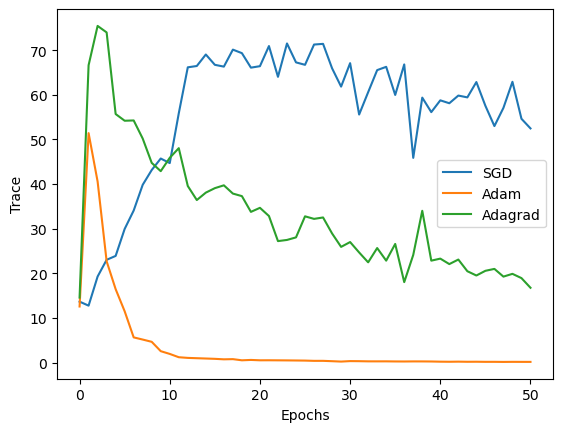

In [12]:
plt.plot(traces_SGD, label='SGD')
plt.plot(traces_Adam, label='Adam')
plt.plot(traces_adagrad, label='Adagrad')
plt.xlabel('Epochs')
plt.ylabel('Trace')
plt.legend()
plt.show()